Analyzing n-tuples in some databases
==

One of the first exercises in Pattern Theory deals with patterns of n-tuples in databases. Here, we look at the occcurence of successive letters and words in an English text. I chose Pride and Prejudice, since it is the most popular book on Project Gutenberg, and it's also a pretty good book in its own right.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import numpy as np
import pandas as pd

Downloading the text and preprocessing
--

Let's begin by downloading the book from Project Gutenberg and extracting the actual content from our download (the book file has a preamble and a license file, which we don't need). We're using the `requests` library because of its clean api, and we're searching for the first and last line of the book to extract the book content from our download.

In [2]:
import requests
resp = requests.get('http://www.gutenberg.org/cache/epub/1342/pg1342.txt')
print resp.text[:200]

﻿The Project Gutenberg EBook of Pride and Prejudice, by Jane Austen

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it aw


In [3]:
text_start_line = 'It is a truth universally acknowledged'
text_end_line = 'End of the Project Gutenberg EBook of Pride and Prejudice, by Jane Austen'

In [4]:
text = resp.text
text = text[text.find(text_start_line):text.find(text_end_line)]

Let's have a look at the beginning and the end of the book. As you can see below, there's quite a bit of extraneous whitespace, but we will filter that out in our next step.

In [5]:
print text[:160]

It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

However little known the feelings or v


In [6]:
print text[-160:]

hey were both ever
sensible of the warmest gratitude towards the persons who, by bringing
her into Derbyshire, had been the means of uniting them.








In [7]:
type(text)

unicode

In [8]:
len(text) / 1024.0  # Size of the book in kB.

681.3955078125

To facilitate our corpus a bit, we will convert it to lowercase, we'll remove anything that isn't 'a' to 'z' or a space, and we'll collapse successive sequences of whitespace into single spaces. This is easily done with Python's `re` module; for more complex preprocessing tasks the [`regex` library](https://pypi.python.org/pypi/regex) is often a good fit. This is especially the case if you're dealing with Unicode. As our text is fully within the good old ASCII realm, we'll just stick with `re`.

In [9]:
import re
text = text.encode('ascii')
text = text.lower()
text = re.sub("[^a-z\s]+", "", text)
text = re.sub("\s+", " ", text)

In [10]:
print text[:160]

it is a truth universally acknowledged that a single man in possession of a good fortune must be in want of a wife however little known the feelings or views of


Individual letter counts
--

This leaves us with a sanitized version of the text, which we'll use for our subsequent analysis. The first thing that we can do is to take a look at the counts of individual characters: while this doesn't teach us anything new, it serves as a good test to check that all is well and nothing went wrong during our preprocessing step. We see that space is the most common character, followed by 'e', 't', 'a', and so on, just as we'd expect.

In [11]:
# Counts of individual letters.
from collections import Counter
counter = Counter(text)
print counter.most_common(27)

[(' ', 121463), ('e', 69366), ('t', 46641), ('a', 41681), ('o', 40039), ('i', 37830), ('n', 37687), ('h', 34066), ('s', 33109), ('r', 32295), ('d', 22299), ('l', 21592), ('u', 14985), ('m', 14764), ('c', 13460), ('y', 12706), ('w', 12305), ('f', 12000), ('g', 10030), ('b', 9087), ('p', 8224), ('v', 5726), ('k', 3208), ('z', 936), ('j', 871), ('x', 839), ('q', 627)]


To make a plot, we'll put the contents of the counter into a Pandas Series object, which is basically a 1-dimensional data structure with custom labels. For now, Pandas just gives us nice formatting and plotting options; later on we'll use some of its more advanced functionality.

In [12]:
import string
letters = list(string.lowercase) + [' ']
counts = pd.Series(
    index=letters,
    data=[counter[letter] for letter in letters]
)

In [13]:
pdf = counts / np.sum(counts)

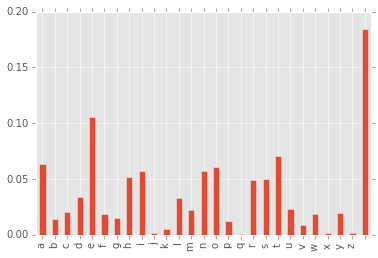

In [14]:
pdf.plot(kind='bar')

Lastly, let's calculate the entropy of the single-letter distribution. The _entropy_ of a discrete probability density function is given by $H = \sum_i p_i \log_2 p_i$ and measures the average information (in bits) in a sample drawn from this distribution. If all characters were equally likely (i.e. the pdf is uniform), we'd need $\log_2(27) \approx 4.75$ bits to represent the individual characters. The fact that the entropy is lower indicates that there's a certain degree of redudancy in our a-to-z encoding.

In [15]:
H = -np.dot(pdf, np.log2(pdf))
print H

4.09931661652


Conditional probabilities for digrams
--

Let's take a quick look at the probability density for letter pairs, and the probability $P(\ell_1 | \ell_0)$ that a letter $\ell_1$ occurs, given that the letter preceding it is $\ell_0$. We get this PDFs in essentially the same way as the single-letter PDF, by counting occurrences of letter pairs (digrams) and normalizing.

In [16]:
digrams = zip(text[:-1], text[1:])

In [17]:
digrams[:10]

[('i', 't'),
 ('t', ' '),
 (' ', 'i'),
 ('i', 's'),
 ('s', ' '),
 (' ', 'a'),
 ('a', ' '),
 (' ', 't'),
 ('t', 'r'),
 ('r', 'u')]

In [18]:
counts = Counter(digrams)

In [19]:
counts.most_common(5)

[(('e', ' '), 21949),
 ((' ', 't'), 15969),
 (('h', 'e'), 14823),
 (('t', 'h'), 13748),
 (('d', ' '), 13739)]

In [20]:
first_letter, second_letter = zip(*counts.keys())
values = counts.values()

This information fits very naturally into a pandas DataFrame. A DataFrame is basically a big table with an index labeling the rows, and one or several columns. We put our counts into a dataframe, and in the last step we obtain the PDF by summing over the counts column and dividing the individual counts by that sum.

In [21]:
p2 = pd.DataFrame({
    'First Letter': first_letter,
    'Second Letter': second_letter,
    'Count': values
}, columns=['First Letter', 'Second Letter', 'Count'])

p2['Count'] /= p2['Count'].sum()

To get the conditional PDF in a form that actually tells us something, we first turn `p2` into a _pivot table_, a table in which the row axis is labeled by the first letter, the columns by the second letter, and the table entries are probabilities. This allows to easily sum over the rows so that we get the conditional probability by the formula $$P(\ell_1 | \ell_0) = \frac{P(\ell_1 \ell_0)}{P(\ell_0)}.$$
You may wonder about the `fillna` command in the last step --- it turns out that there are certain digrams, like 'qx', which don't occur at all in our text. When we created our pivot table, Pandas represented those as NaN (not a number).  Given that those diagrams actually have probability 0, we replace all NaNs by 0 with `fillna`.

In [22]:
frequency_table = p2.pivot(index='First Letter', columns='Second Letter', values='Count')
conditional_pdf = frequency_table.div(frequency_table.sum(axis=1), axis=0)
conditional_pdf = conditional_pdf.fillna(0)

In [23]:
conditional_pdf.loc['a':'f', 'a':'f']  # Just a slice, so we don't fill the whole page with numbers.

Second Letter,a,b,c,d,e,f
First Letter,,,,,,
a,0.000168,0.036875,0.026751,0.058012,0.000144,0.011132
b,0.031804,0.000770,0.000000,0.000110,0.458237,0.000000
c,0.103938,0.000074,0.024071,0.000223,0.184324,0.000000
d,0.047760,0.000359,0.000045,0.009238,0.113906,0.001121
e,0.045008,0.000764,0.023513,0.077920,0.027247,0.009817
f,0.065583,0.000083,0.000500,0.000500,0.093083,0.047917


Getting useful info out of the full 27x27 table is not that straightforward, so let's plot the probabilities instead.

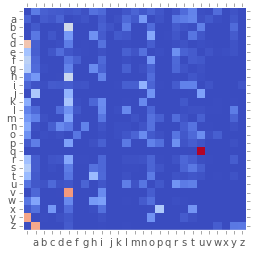

In [24]:
plt.imshow(conditional_pdf, interpolation='none', cmap='coolwarm')
labels = conditional_pdf.index
_ = plt.xticks(range(len(labels)), labels)
_ = plt.yticks(range(len(labels)), labels)
plt.grid(False)

The one feature that immediately stands out from the plot is that the probability to have 'q' followed by 'u' is very high, whereas the probability to have any other letter following 'q' is essentially zero, just as we'd expect. Let's take a slice of our dataframe and look at the numbers.

In [25]:
conditional_pdf.loc['q']

Second Letter
                 0.001595
a                0.000000
b                0.000000
c                0.000000
d                0.000000
e                0.000000
f                0.000000
g                0.000000
h                0.000000
i                0.000000
j                0.000000
k                0.000000
l                0.000000
m                0.000000
n                0.000000
o                0.000000
p                0.000000
q                0.000000
r                0.000000
s                0.000000
t                0.000000
u                0.998405
v                0.000000
w                0.000000
x                0.000000
y                0.000000
z                0.000000
Name: q, dtype: float64

The first entry in the table above represents the space character, and this initially baffled me. What word in the English language ends in 'q'? Let's find out.

In [26]:
def find_words(substring):
    """Return a list of all words that contain a given substring.
    """
    substring = substring.replace(' ', '\s')
    regexp = '(?P<word>\w*{}\w*)'.format(substring)
    return [match.groupdict()['word'] for match in re.finditer(regexp, text)]

In [27]:
find_words('qu')[:10]

['quickness',
 'quick',
 'acquainted',
 'acquaintance',
 'quite',
 'acquaintance',
 'acquaintance',
 'acquaintances',
 'questions',
 'quite']

In [28]:
find_words('q ')[:10]

['esq to']

"Esq" --- that explains a lot!

To conclude this part, let's look at the entropies of the distributions $P(\ell_1 | \ell_0)$ for fixed values of $\ell_0$. The entropy for $P(\ell_1 | \ell_0 = q)$ is almost zero, since if a 'q' occurs, we know it's almost certain that the next letter will be a 'u'. By contrast, the entropy for $P(\ell_1 | \ell_0 = \mathrm{space})$ is quite high, indicating that essentially anything can follow a space.

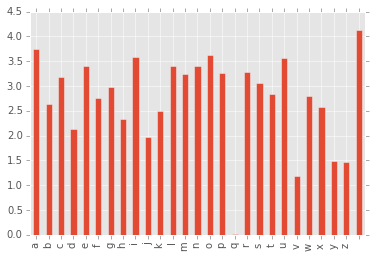

In [29]:
from scipy.stats import entropy

conditional_entropy = pd.Series(
    index=letters,
    data=[entropy(conditional_pdf.loc[letter], base=2) for letter in letters]
)
conditional_entropy.plot(kind='bar')

Shannon's game: probabilistically generating a new text
--

We can play the same game for trigrams, quadgrams, and other higher-order word snippets. Let's be a bit more organized and create some functions to do the heavy lifting for us. We'll also change our terminology and talk about "tokens" instead of letters, since it turns out that these functions can equally well be applied to texts made up of arbitrary collections of tokens.

In [30]:
def get_ngrams(text, n=3):
    """Create a list of n-grams from a given text.
    """
    return zip(*[text[k:k - n] for k in range(n)])

In [31]:
# Print the first 10 quadgrams in the book.
quadgrams = get_ngrams(text, 4)
for quadgram in quadgrams[:10]:
    print ''.join(quadgram)

it i
t is
 is 
is a
s a 
 a t
a tr
 tru
trut
ruth


In [32]:
def pdf(ngrams):
    """Return a PDF given a list of n-grams.
    """
    counter = Counter(ngrams)
    pdf = pd.Series(index=counter.keys(), data=counter.values())
    pdf /= pdf.sum()
    return pdf

In [33]:
p4 = pdf(quadgrams)
p4.sort(ascending=False); p4

( , t, h, e)    0.009896
(t, h, e,  )    0.006585
( , t, o,  )    0.006274
(a, n, d,  )    0.005699
( , o, f,  )    0.005469
( , a, n, d)    0.005363
(i, n, g,  )    0.004880
(h, e, r,  )    0.004725
( , h, e, r)    0.003914
( , y, o, u)    0.003147
(h, a, t,  )    0.003139
( , t, h, a)    0.002893
( , i, n,  )    0.002831
( , w, a, s)    0.002805
(w, a, s,  )    0.002805
...
(e, n, b, u)    0.000002
( , s, m, o)    0.000002
(u,  , u, p)    0.000002
(o, b, e, i)    0.000002
( , e, n, r)    0.000002
(g,  , k, e)    0.000002
( , e,  , g)    0.000002
(r, e, d, r)    0.000002
(x, i, g, e)    0.000002
(l, e, f, o)    0.000002
(e, v, a, b)    0.000002
(o, r, e, b)    0.000002
(e, n, f, o)    0.000002
(a, u, g, u)    0.000002
(g, t, o, n)    0.000002
Length: 16280, dtype: float64

Finally, we construct the conditional PDF expressing the probability of a token given the previous $n$ tokens. This requires a bit of Pandas magic; basically we pull the PDF on $n + 1$ tokens apart so we can marginalize over the last token, and then we normalize.

In [34]:
def conditional_pdf(text, n):
    """Return the conditional PDF for a token given n previous tokens from an alphabet.
    """
    pdf_n = pdf(get_ngrams(text, n + 1))

    # Replace the index on pdf_n, which consists of (n+1)-tuples, by a MultiIndex
    # on two levels, where the first level is labeled by the first n elements in the tuple,
    # and the second level by the remaining element.
    def split_tuple(ix):
        return ix[:-1], ix[-1]
    pdf_n.index = pd.MultiIndex.from_tuples([split_tuple(ix) for ix in pdf_n.index])
    
    # Marginalize over the last letter to get the PDF of (n-1)-grams.
    m = pdf_n.groupby(level=[0]).sum()

    # Normalize by the marginalized distribution.
    return pdf_n.div(m, level=0)

In [35]:
c4 = conditional_pdf(text, 4)

Sanity check: given that the first four characters are 'hear', what are the possible subsequent characters and their probabilities?

In [36]:
c4.loc[('h', 'e', 'a', 'r')]

t    0.250000
e    0.003968
i    0.099206
s    0.003968
     0.285714
d    0.357143
dtype: float64

In [37]:
# These probabilities should sum to 1.0 .
c4.loc[('h', 'e', 'a', 'r')].sum()

1.0

We're now in a position to play Shannon's game. Given an initial n-gram $\ell_1 \cdots \ell_n$, we'll draw a sample from $P(\ell | \ell_1 \cdots \ell_n)$, emit that, and repeat. This should give us something that at least vaguely resembles our original text.

In [38]:
import numpy

def generate_text(conditional_pdf, initial, length=1000):
    """Play Shannon's game!
    """
    if isinstance(initial, str):
        initial = tuple(initial)

    for _ in xrange(length):
        pdf = conditional_pdf.loc[initial]
        next_token = numpy.random.choice(pdf.index, p=pdf)
        initial = (initial + (next_token, ))[1:]
        yield next_token

As we take more and more of the history into account, that is, when $n$ increases, we expect to get more and more "plausible" representations of the text. Let's check this by generating a string of 250 characters taking into account the previous 2, 3, 4, 5 characters. As you can see below, the output for $n = 2$ consists of completely garbled nonsense with the occasional word fragment showing up, whereas for $n = 5$ we get a nice stream-of-conciousness in the style of the original text. For me, $n = 4$ is the cutest, with portmanteaus such as "regimentioned" :-)

In [39]:
c2 = conditional_pdf(text, 2)
print ''.join(generate_text(c2, 'he', 250))

ninquesto here the quetter dowerst th poselingley uncened wishe it sou bennethe crionly he in othavieve but beffectellet of i knoid hat no thersed ung whe grid susester to sen to she wonly haptimme heits wersest i th whin ande ance a he oth cand to t


In [40]:
c3 = conditional_pdf(text, 3)
print ''.join(generate_text(c3, 'hea', 250))

r from you have subjects timention you hapterwishe guill crect and i amust is not was to darcy volutiful the uncle and one chem withe was thanimagined bing fortial of mation cons assipid nexteen conquite had but sisterwarded mr days and life that ins


In [41]:
c4 = conditional_pdf(text, 4)
print ''.join(generate_text(c4, 'hear', 250))

d him i had he first write employments they were on the met elizabeth in her times behaving is long ordained told made elizabeth it they had seekindness bingley forsters was overheart i have not depend would perfected to be scarcely letter and if i s


In [42]:
c5 = conditional_pdf(text, 5)
print ''.join(generate_text(c5, 'heart', 250))

ening which make the against him her uncle and almost delivered abundants cooking our it and conduct of my affection for a most earnest most resolved in her forgive which will only on your fine eyelashes charlottes of brother not at least in the you 


Finding word boundaries via the binding energy
--

Using relative probabilities, we can also get an idea of where the word boundaries are in our text. We'll delete the spaces from our text, leaving a string "itisatruthuniversallyacknowledged..." 

For each 4-gram $abcd$, we expect to have a word boundary between $ab$ and $cd$ when these two digrams are (more or less) independent. Inside a word, we'd expect $cd$ to be determined at least partially by $ab$. To turn this into something more concrete, we define the _binding energy_ $E(abcd)$ by
$$
  E(abcd) = \log_2 \frac{P(abcd)}{P(ab) P(cd)}.
$$
When $E(abcd)$ is low, $P(abcd) \approx P(ab) P(cd)$ and $ab$ and $cd$ are relatively independent, hinting at a word boundary. By contrast, when $E(abcd)$ is high, $cd$ is highly determined by $ab$ and we expect to be inside a word. Looking for minima in $E$ will therefore give us an indication of possible word boundaries.

In [43]:
words = text.split()
text_nospaces = ''.join(words)
word_lengths = np.array([len(word) for word in words])
word_boundaries = np.cumsum(word_lengths)
print text_nospaces[:80]
print word_boundaries[:10]

# The start_word_mask is True when the corresponding letter is the first letter in a word, and False otherwise.
start_word_mask = np.zeros(len(text_nospaces), dtype=bool)
start_word_mask[word_boundaries[:-1]] = True
start_word_mask[0] = True

print start_word_mask[:20]

itisatruthuniversallyacknowledgedthatasinglemaninpossessionofagoodfortunemustbei
[ 2  4  5 10 21 33 37 38 44 47]
[ True False  True False  True  True False False False False  True False
 False False False False False False False False]


In [44]:
truncate_length = 1000
text_nospaces = text_nospaces[:truncate_length]
energy = np.zeros(truncate_length, dtype=float)

In [45]:
quadgrams = get_ngrams(text_nospaces, n=4)
digrams = get_ngrams(text_nospaces, n=2)

pdf4 = pdf(quadgrams)
pdf2 = pdf(digrams)

In the below, we slide a moving quadgram window over the text to obtain successive quadgram probabilities (and similarly for digrams). Pandas makes this easy: all we have to do is to provide a list of quadgrams to the `.loc` attribute.

In [46]:
# Below, we work with the underlying numpy arrays directly (as indicated by the .values property),
# since all we care about is the ordered data, and the index gets in the way here.

quadgram_probabilities = pdf4.loc[quadgrams].values
digram_probabilities = pdf2.loc[digrams].values

energy = np.log2(quadgram_probabilities / (digram_probabilities[:-2] * digram_probabilities[2:]))

Let's make a plot of the binding energy. The interpretation is fairly straightforward: the brown line indicates the binding energy, while the solid black vertical lines indicate the true word boundaries (remember, we saved those in a boolean mask `start_word_mask` earlier on).

/Users/jvkersch/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


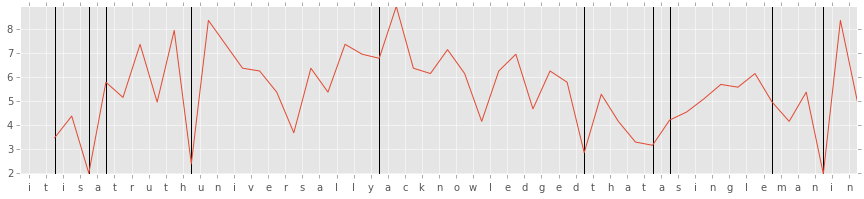

In [47]:
# Change these two parameters to visualize other areas of the text.
plot_start, plot_end = 0, 50

energy_start = max(plot_start, 2)
energy_end = min(plot_end, len(energy) - 2)
energy_range = energy[energy_start-2:energy_end-2]
energy_min, energy_max = np.min(energy_range), np.max(energy_range)

fig = plt.figure(figsize=(15, 3), dpi=80)
ax = fig.add_subplot(111)

ax.xaxis.set_ticks(range(plot_start, plot_end))
ax.xaxis.set_ticklabels(text_nospaces[plot_start:plot_end])

r = np.arange(plot_start, plot_end)
boundary_locations = r[start_word_mask[plot_start:plot_end]]
ax.vlines(boundary_locations -0.5,energy_min, energy_max)

ax.plot(-0.5 + np.arange(energy_start, energy_end), energy_range)
ax.set_ylim((energy_min, energy_max))

fig.show()

In the plot above, you can see that the minima of the binding energy $E$ do pick up some of the (more obvious) word boundaries, like the boundary after the word 'is', the suffix '-ed', and the word 'man'. There are quite a bit of false positives too, so most likely we could do some postprocessing and improve our results. There's a better method of finding word boundaries however, involving dynamic programming, which will be explained in a future notebook.

Word probabilities and Zipf's law
--

Last, to demonstrate that our methods work equally well on the word-level, let's do some word analysis. Let's begin by investigating the probabilities of individual words in our text.

(This is work-in-progress)

In [48]:
words = text.split()
pdf_words = pdf(words)
pdf_words.sort(ascending=False)

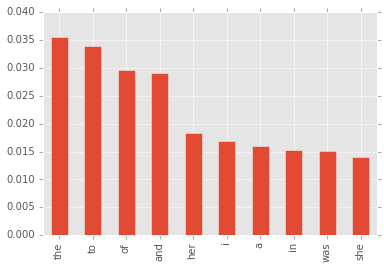

In [49]:
pdf_words[:10].plot(kind='bar')

There's no obvious pattern here, until we include some more data in our plot.

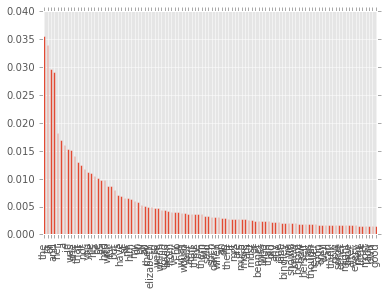

In [50]:
pdf_words[:100].plot(kind='bar')

Shannon's game for word digraphs
--

Finally, let's play Shannon's game on the word level. That is, given $n$ initial words $w_1, \ldots, w_n$ we sample from the distribution $P(w | w_1, \ldots, w_n)$ to obtain the next word, and we repeat this to obtain a stochastically generated text. Given that our encoding (using a Pandas dataframe on a MultiIndex) is sparse, we can essentially do this for any $n$, but if you look at the conditional probabilities for trigrams below, you'll see that they are all quite close to 1.0, indicating that we've removed much of the randomness at that stage.

In [51]:
# Generate the conditional PDF.
c_words = conditional_pdf(words, 3); c_words

(they, are, wanted)      in           1.00
(no, pleasure, in)       it           0.25
(to, retain, the)        right        1.00
(better, she, replied)   if           1.00
(of, them, pronounced)   him          1.00
(when, any, dish)        on           1.00
(in, the, shire)         she          0.50
(that, a, person)        who          1.00
(of, recreation, and)    amusement    1.00
(so, splendid, a)        dinner       1.00
(and, even, horror)      oppressed    1.00
(who, had, known)        him          1.00
(when, they, next)       met          1.00
(added, you, will)       of           1.00
(the, highest, opinion)  in           0.75
...
(left, the, country)            miss       0.5
(in, his, absence)              she        1.0
(married, all, day)             but        1.0
(with, what, the)               owner      1.0
(complete, my, disappointment)  would      1.0
(and, for, all)                 the        1.0
(in, taking, so)                decided    1.0
(spoilt, by, admitting

In [52]:
c2 = conditional_pdf(words, 2)
print ' '.join(generate_text(c2, ('they', 'are'), 40))

destined for his features are not usually influenced by my honest confession of the house was engaged by the awkwardness of the inn was under frequent discussion between her sisters was then left to him and on the contrary could


In [53]:
c3 = conditional_pdf(words, 3)
print ' '.join(generate_text(c3, ('they', 'are', 'wanted'), 40))

in the farm mr bennet are they not they are wanted in the farm mr bennet are they not they are wanted in the farm mr bennet are they not they are wanted in the farm much oftener than i


In [54]:
c4 = conditional_pdf(words, 4)
print ' '.join(generate_text(c4, ('they', 'are', 'wanted', 'in'), 100))

the farm mr bennet are they not they are wanted in the farm mr bennet are they not they are wanted in the farm mr bennet are they not they are wanted in the farm mr bennet are they not they are wanted in the farm mr bennet are they not they are wanted in the farm much oftener than i can get them but if you have got them today said elizabeth my mothers purpose will be answered she did at last extort from her father an acknowledgment that the horses were engaged jane was therefore obliged to go
